# AB-тест

**Описание** : Команда ML разработала новый алгоритм рекомендательной постов. На тестовой группе (2) был использован новыый алгоритм. Необходимо проверить гипотезу о том, что новый алгоритм рекомендации постов во 2-й группе приведет к увеличению CTR.


**Задачи** : По данным с '2024-08-02 по 2024-08-08':

1. Проверить гипотезу о том, что новый алгоритм рекомендации постов во 2-й группе приведет к увеличению CTR
2. Написать рекомендацию, стоит ли раскатывать новый алгоритм на всех новых пользователей.

**Рассмтариваемый показатель** : CTR, сглаженный ctr
**Используемые методы** : t-test, Mann-Whitney U test, Пуассоновский бутстреп, тест Манна-Уитни поверх бакетного преобразования

In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


sns.set_style("whitegrid", {"axes.facecolor": "white"})

## 1 Подготовка данных

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240820',
'user':'student',
'password':'dpo_python_2020'
}

#текст запроса
query = '''
select user_id, countIf(action='view')  as views, countIf(action='like')  as likes, countIf(action='like')/countIf(action='view') as ctr, exp_group
from simulator_20240820.feed_actions
where toDate(time) between '2024-08-02' and '2024-08-08'  and exp_group in [1,2]
group by user_id, exp_group
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection)

In [3]:
df.head()

,user_id,views,likes,ctr,exp_group
0,109963,15,3,0.200000,1
1,26117,141,32,0.226950,1
2,138232,73,18,0.246575,1
3,26295,141,39,0.276596,1
4,18392,32,7,0.218750,1


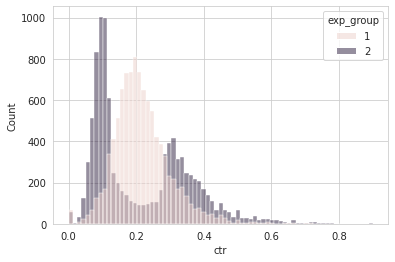

In [4]:
sns.histplot(data=df, x='ctr', hue='exp_group')
plt.show()

Распределение исследуемой величины в двух группах отличается, что может говорить о воздействие новой рекомендательной системы.

## 1.1 Расчёт сглаженного ctr

In [5]:
# Расчёт глобального CTR

global_ctr1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

df['global_ctr'] = df['exp_group'].apply(
    lambda x: global_ctr1 if x==1 else global_ctr2)

In [6]:
# Расчёт сглаженного ctr

df['smothed_ctr'] = (df['likes'] + 5 * df['global_ctr'])/(df['views'] + 5)

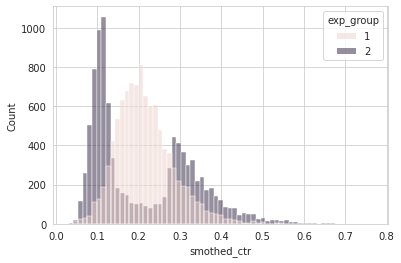

In [7]:
# Распределение сглаженного ctr

sns.histplot(data=df, x='smothed_ctr', hue='exp_group')
plt.show()

In [8]:
df.groupby('exp_group')['ctr'].agg(['mean', 'median'])

,mean,median
exp_group,,
1,0.216774,0.205882
2,0.216102,0.153285


## 2 Анализ CTR в двух группах

### Формирование гипотез:
- H0: CTR контрольной группы и CTR эспериментальной группы не различаются 
- H1: CTR контрольной группы и CTR эспериментальной группы различаются

### 2.1 t-test ctr

In [9]:
pvalue_ttest = stats.ttest_ind(df[df.exp_group == 1]['ctr'], df[df.exp_group == 2]['ctr'], equal_var=False).pvalue

### 2.2 тест Манна-Уитни

In [10]:
pvalue_MannWhitneytest = stats.mannwhitneyu(df[df.exp_group == 1]['ctr'], df[df.exp_group == 2]['ctr']).pvalue

### 2.3 t-test на сглаженном CTR

In [11]:
pvalue__ttest_smoothed_ctr = stats.ttest_ind(df[df.exp_group == 1]['smothed_ctr'], df[df.exp_group == 2]['smothed_ctr'], equal_var=False).pvalue

In [12]:
pvalue_Mann_smoothed_ctr = stats.mannwhitneyu(df[df.exp_group == 1]['smothed_ctr'], df[df.exp_group == 2]['smothed_ctr']).pvalue

### 2.4 Пуассоновский бутстреп

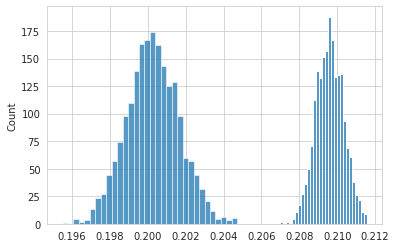

In [13]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)
plt.show()

In [14]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2024-08-02' and '2024-08-08'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
pvalue_bucket = stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided').pvalue

In [15]:
pvalue_diction = {'t_test':pvalue_ttest, 'MannWhitneytest':pvalue_MannWhitneytest, 'ttest_smoothed_ctr':pvalue__ttest_smoothed_ctr, 'MannWhitneytest_smoothed_ctr':pvalue_Mann_smoothed_ctr, 'bootstrap':0, 'bucket':pvalue_bucket}
pd.DataFrame(list(pvalue_diction.items()), columns=['method', 'p-Value'])

,method,p-Value
0,t_test,6.853733e-01
1,MannWhitneytest,4.632206e-45
2,ttest_smoothed_ctr,5.166679e-02
3,MannWhitneytest_smoothed_ctr,2.396534e-50
4,bootstrap,0.000000e+00
5,bucket,2.657643e-07


## Выводы: 
- При проведение различных методов проверки гипотез определена статистическая значимость различия CTR в двух группах.   
- t-test показал, что различие ctr не значимо, в отличии от других тестов, что не позволяет отвергнуть гипотезу о равенстве ctr в двух группах, однако это связвно с тем, что показатель ctr во 2 группе имеет скошенное распределение.
- Большинство тестов показало различие статистически значимым. В средних значениях оно составляет 0.06%, а медианное значение упало на 5%. Данные метрики могут говорить, что рекомендательные системы могли снизить ctr. В связи с этим рекомендую не выкатывать данный алгоритм на всех пользователей.  